In [28]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as im
import pandas as pd
import os 
from pathlib import Path
import cv2
import threading
from scipy.ndimage import binary_fill_holes

# UTILS

In [29]:
old_dir = './FishImgDataset'
resized_dir = './resized-dataset'

labels = ['Glass Perchlet', 'Gold Fish',
          'Gourami', 'Jaguar Gapote', 'Mosquito Fish']

def setup_dir(labelName):
    Path(f"{resized_dir}/train/{labelName}").mkdir(parents=True,exist_ok=True)
    Path(f"{resized_dir}/val/{labelName}").mkdir(parents=True,exist_ok=True)

for label in labels:
    setup_dir(label)


# SETUP DATASET

In [30]:

def importImages(path):
    images = []
    folder_path = path
    nama_files = os.listdir(folder_path)
    for nama_file in nama_files:
        # print(nama_file.split('.')[1])
        if nama_file.split('.')[1] != 'gif':
            file_path = os.path.join(folder_path, nama_file)
            image = cv2.imread(file_path, cv2.IMREAD_COLOR)
            images.append(image)
    return images

In [31]:
def resizeImage(image):
    size = 100
    result = cv2.resize(image,(size,size))
    return result

In [32]:
def prepare_image(labelName,typename):
    images = importImages(f"{old_dir}/{typename}/{labelName}")
    for index, image in enumerate(images):
        try:
            res = resizeImage(image)
            filename = f"img{index}.png"
            plt.imsave(f"{resized_dir}/{typename}/{labelName}/{filename}",res)
        except Exception as e:
            errs.append(f"file: {typename}/{labelName}/{filename} , error: {e}")


In [33]:
from tqdm import tqdm
import threading

In [34]:
dirs = labels
errs = []
# prepare_image(labels[0],'train')
for label in tqdm(dirs):
    t1 = threading.Thread(target=prepare_image,args=(label,'train'))
    t2 = threading.Thread(target=prepare_image,args=(label,'val'))
    # t3 = threading.Thread(target=prepare_image,args=(label,'test'))
    t1.start()
    t2.start()
    # t3.start()
    t1.join()
    t2.join()
    # t3.join()

100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


In [35]:
print(errs)

[]


# Masking

In [36]:
from scipy.ndimage import binary_fill_holes
s1 = cv2.imread('./resized-dataset/train/Glass Perchlet/img0.png')
s2 = cv2.imread('./resized-dataset/train/Gold Fish/img0.png')
s3 = cv2.imread('./resized-dataset/train/Gourami/img0.png')
s4 = cv2.imread('./resized-dataset/train/Jaguar Gapote/img0.png')
s5 = cv2.imread('./resized-dataset/train/Mosquito Fish/img0.png')
sources = [s1,s2,s3,s4,s5]

In [37]:
def show_img(img):
  plt.figure(figsize=(10, 10))
  for i in range(len(img)):
    plt.subplot(1, len(img), i+1)
    plt.imshow(img[i], cmap='gray')

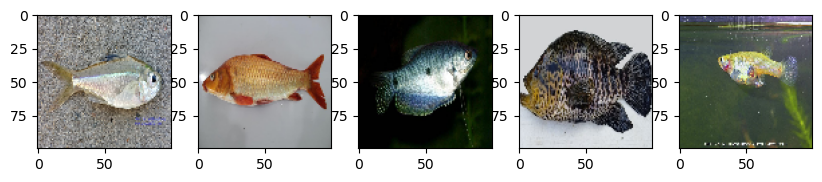

In [38]:
show_img(sources)

75.84437499999999


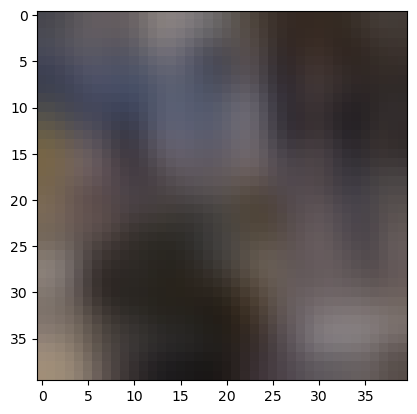

In [39]:
center = sources[3][30:70, 30:70]
center = cv2.GaussianBlur(center,(11,11),0)
# center =cv2.cvtColor(center)
plt.imshow(center,'gray')
print(center.mean(0).mean(0).mean(0))

In [40]:

def wrap_padding(src: np.ndarray, size=1) -> np.ndarray:
    src_x, src_y = src.shape
    result = np.zeros((src_x+(size*2),src_y+(size*2)))

    # wrap padding corner
    result[:-size*2, :-size*2] = src
    result[size*2:, :-size*2] = src
    result[size*2:, size*2:] = src
    result[:-size*2, size*2:] = src
    # wrap padding lrtb
    result[:-size*2, size:-size] = src
    result[size*2:, size:-size] = src
    result[size:-size, size*2:] = src
    result[size:-size, :-size*2] = src
    
    # center
    result[size:-size, size:-size] = src
    return result

def median_filter(src: np.ndarray, size=3):
    src_pad = np.pad(src, (size-1)//2, "wrap")
    x_axis, y_axis = src.shape
    result = np.zeros_like(src)
    for y in range(y_axis):
        for x in range(x_axis):
            m33 = src_pad[x : x + size, y : y + size]
            flat = np.sort(m33.flatten())
            result[x, y] = flat[(flat.size+1)//2]
    return result

# filter mean / blur filter
def mean_filter(src:np.ndarray, size = 3):
    src_pad = wrap_padding(src, (size-1)//2)
    x_axis, y_axis = src.shape
    result = np.zeros_like(src)
    for y in range(y_axis):
        for x in range(x_axis):
            m33 = src_pad[x : x + size, y : y + size]
            flat = (m33.sum()) / m33.size
            result[x, y] = flat
    return result

In [41]:
kernel = np.array([
    [1,1,1],
    [1,1,1],
    [1,1,1],
]
)
def padding(citra: np.ndarray):
    xcitra, ycitra = citra.shape
    xkernel, ykernel = kernel.shape
    out = np.zeros((xcitra+xkernel-1, ycitra+ykernel-1))
    out[xkernel//2:-(xkernel//2),ykernel//2:-(ykernel//2)] = citra
    return out

def erosi(citra:np.ndarray):
    xkernel, ykernel = kernel.shape
    #kernel sum
    ksum = kernel.sum() * citra.max()
    src = padding(citra)
    result = np.zeros(citra.shape)
    for y in range(citra.shape[1]):
        for x in range(citra.shape[0]):
            temp = src[x:x+xkernel, y:y+ykernel]
            if temp.size != kernel.size:
                continue
            temp_sum = (temp * kernel).sum()
            if(temp_sum == ksum):
                result[x,y] = 1

    return result

def dilasi(citra:np.ndarray):
    xkernel, ykernel = kernel.shape
    src = padding(citra)
    result = np.zeros(citra.shape)
    for y in range(citra.shape[1]):
        for x in range(citra.shape[0]):
            temp = src[x:x+xkernel, y:y+ykernel]
            if temp.size != kernel.size:
                continue
            temp_sum = (temp * kernel).sum()
            if(temp_sum != 0):
                result[x,y] = 1
  
    return result

def opening(citra: np.ndarray):
    t = erosi(citra)
    return dilasi(t)

In [64]:
def normalize(src: np.ndarray, max:int = 255):
    vmin, vmax = src.min(), src.max()
    temp = np.array(((src - vmin)/ (vmax - vmin)) * max, dtype=np.float32)
    return np.array(temp,np.int64)

In [65]:
def mask_fish(image):
    # Preprocess
    
    src = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #center image
    center = src[30:70, 30:70]
    center = mean_filter(center,7)
    
    #image 
    #blur with mean filter
    src = mean_filter(src,7)
    #median filter
    src = median_filter(src,5)

    # get mean
    mean = np.mean(src)
    mean_center = np.mean(center)
    # print(f"all: {mean}, center: {mean_center}")

    # Thresholding based on background color
    if mean < mean_center:
        # if avg color is black
        _, mask = cv2.threshold(src, mean, 255, cv2.THRESH_BINARY)
    else:
        _, mask = cv2.threshold(src, mean+10, 255, cv2.THRESH_BINARY_INV)
    #opening
    mask = opening(mask)
    # plt.imshow(mask,'gray')
    mask = binary_fill_holes(mask).astype(np.uint8)
    # mask = np.stack([mask,mask,mask],2)
    masked_image = cv2.bitwise_and(image,image, mask=mask)
    masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    masked_image = normalize(masked_image)

    # plt.imshow(masked_image,'gray')
    return masked_image

min: 0 max: 255


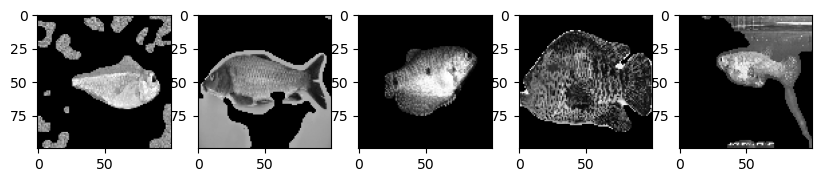

In [66]:
res = []
# _=mask_fish(sources[0])
for item in sources:
    res.append(mask_fish(item))
print(f"min: {res[0].min()} max: {res[0].max()}")
show_img(res)

# Ekstraksi Ciri Tekstur

In [67]:
folders = {
    'perchlet': './resized-dataset/train/Glass Perchlet/',
    'gold': './resized-dataset/train/Gold Fish/',
    'gourami': './resized-dataset/train/Gourami/',
    'jaguar': './resized-dataset/train/Jaguar Gapote/',
    'mosquito': './resized-dataset/train/Mosquito Fish/'
}
folders_val = {
    'perchlet': './resized-dataset/val/Glass Perchlet/',
    'gold': './resized-dataset/val/Gold Fish/',
    'gourami': './resized-dataset/val/Gourami/',
    'jaguar': './resized-dataset/val/Jaguar Gapote/',
    'mosquito': './resized-dataset/val/Mosquito Fish/'
}

labels = {
    'perchlet': 0,
    'gold': 1,
    'gourami': 2,
    'jaguar': 3,
    'mosquito': 4
}
header = [
        'contrast',
        'homogeneity',
        'dissimilarity',
        'asm',
        'energy',
        'correlation'
]

In [68]:
from skimage.feature import graycoprops

def extract_texture(glcm_4_degs):
    res = []
    properties = ['contrast', 'homogeneity', 'dissimilarity', 'ASM', 'energy','correlation']
    datas = [value for name in properties for value in graycoprops(glcm_4_degs, name )[0]]
    for item in datas:
        res.append(item)
    return res 


In [69]:
import threading
from tqdm.auto import tqdm
from skimage.feature import graycomatrix


def do_extraction(folders: dict, destination: list):
    images_with_num = {}
    d45 = np.pi / 8
    d90 = np.pi / 4
    d135 = d90 + d45
    for path in folders:
        label_num = labels[path]  # number label
        path = folders[path]  # get folder path based on label key
        # load images in a folder / label
        images = importImages(path)
        images_with_num[label_num] = images

    for label, images in images_with_num.items():
        for image in tqdm(images, leave=False, desc=f"Individual IMG processing label {label}"):
            result = [label]
            masked_image = mask_fish(image)
            if masked_image is not None:
                glcm_data = graycomatrix(
                    masked_image, [1], [0, d45, d90, d135], symmetric=True, levels=256, normed=True)
                result = result + extract_texture(glcm_data)
            destination.append(result)  

In [70]:
train_data = []
val_data = []

# do_extraction(folders,train_data)
t1=threading.Thread(target=do_extraction, args=(folders, train_data)) 
t2=threading.Thread(target=do_extraction, args=(folders_val, val_data))
t1.start()
t2.start()
t1.join()
t2.join()

Individual IMG processing label 0:   0%|          | 0/397 [00:00<?, ?it/s]

Individual IMG processing label 0:   0%|          | 0/124 [00:00<?, ?it/s]

Individual IMG processing label 1:   0%|          | 0/65 [00:00<?, ?it/s]

Individual IMG processing label 2:   0%|          | 0/97 [00:00<?, ?it/s]

Individual IMG processing label 3:   0%|          | 0/72 [00:00<?, ?it/s]

Individual IMG processing label 4:   0%|          | 0/80 [00:00<?, ?it/s]

Individual IMG processing label 1:   0%|          | 0/206 [00:00<?, ?it/s]

Individual IMG processing label 2:   0%|          | 0/311 [00:00<?, ?it/s]

Individual IMG processing label 3:   0%|          | 0/229 [00:00<?, ?it/s]

Individual IMG processing label 4:   0%|          | 0/254 [00:00<?, ?it/s]

In [71]:
column =["label"]
degs = [0,45,90,135]
for head in header:
    for deg in degs:
        column.append(f"{head}_{deg}") 


In [72]:
print(len(column))
print(len(train_data[0]))

25
25


In [73]:
def save_to_csv(data:list, header: list, filename: str):
    with open(f'{filename}.csv','w',encoding="UTF8") as f:
        head = ','.join(header)
        f.write(head + "\n")
        for item in data:
            temp = []
            for data in item:
                temp.append(str(data))
            body = ','.join(temp)
            f.write(body + "\n")
        f.close()

In [75]:
save_to_csv(train_data, column, 'train_dataset_lib')
save_to_csv(val_data, column, 'val_dataset_lib')

# Perbandingan Model

In [94]:
import numpy as np
import pandas as pd
import seaborn as sb
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [95]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

names = [
    "Nearest Neighbors",
    "Decision Tree",
    "Random Forest",
    "Neural Network",
    "Naive Bayes"
]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(max_iter=5000),
    GaussianNB(),
]


In [98]:
datatrain = pd.read_csv('train_dataset_lib.csv')
# datatrain = datatrain.dropna
train_x = datatrain.iloc[:,1:-1]
y_train = datatrain.iloc[:,0]
scaler = MinMaxScaler()
train_x_scaled =  scaler.fit_transform(train_x)
print("Perbandingan data train yang sesudah diskalakan dan sebelum")
print(len(train_x_scaled), len(train_x))

Perbandingan data train yang sesudah diskalakan dan sebelum
1397 1397


In [99]:
dataval = pd.read_csv('val_dataset_lib.csv')
x_val = dataval.iloc[:, 1:-1]
y_val = dataval.iloc[:,0]

scaler = MinMaxScaler()
x_val_scaled = scaler.fit_transform(x_val)

print("Perbandingan data test setelah diskalakan dan belum")
print(len(x_val_scaled), len(x_val))


Perbandingan data test setelah diskalakan dan belum
438 438


In [100]:
for name, model in zip(names, classifiers):
  model.fit(train_x, y_train)
  y_pred_model = model.predict(x_val)
  print(f'Nama Model : {name}')
  print(f'Accuracy : {accuracy_score(y_val, y_pred_model)}')
  print(confusion_matrix(y_val, y_pred_model))
  print(classification_report(y_val, y_pred_model,zero_division=0))
  print('\n')

Nama Model : Nearest Neighbors
Accuracy : 0.6461187214611872
[[108   6   5   3   2]
 [ 20  28   7   8   2]
 [ 34   5  56   1   1]
 [  7   5   3  55   2]
 [ 22   9   9   4  36]]
              precision    recall  f1-score   support

           0       0.57      0.87      0.69       124
           1       0.53      0.43      0.47        65
           2       0.70      0.58      0.63        97
           3       0.77      0.76      0.77        72
           4       0.84      0.45      0.59        80

    accuracy                           0.65       438
   macro avg       0.68      0.62      0.63       438
weighted avg       0.67      0.65      0.64       438



Nama Model : Decision Tree
Accuracy : 0.9611872146118722
[[118   2   4   0   0]
 [  1  60   3   1   0]
 [  2   0  95   0   0]
 [  0   0   0  72   0]
 [  1   0   3   0  76]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       124
           1       0.97      0.92      0.94       